## 导入必要的库 以及颜色设置

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow info and warnings
import pandas as pd
import numpy as np
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from tabulate import tabulate
import missingno as msno
from IPython.display import display_html
from PIL import Image
import gc
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
import plotly.express as px

import os
import random
import re
import math
import time

import warnings

warnings.filterwarnings('ignore') # Disabling warnings for clearer outputs

import matplotlib.pyplot as plt
from matplotlib import rcParams
config = {
        "font.family": 'serif',
        "mathtext.fontset": 'stix',  # matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
        "font.serif": ['SimSun'],  # 宋体
        'axes.unicode_minus': False  # 处理负号，即-号
    }
rcParams.update(config)


seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)

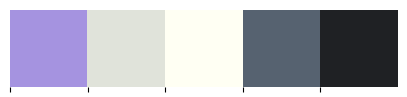

In [3]:
import pydicom  # for DICOM images
from skimage.transform import resize
import warnings
warnings.filterwarnings("ignore")
# Set Color Palettes for the notebook
colors_nude = ['#A593E0','#E0E3DA','#FFFFF3','#566270','#1F2124']
sns.palplot(sns.color_palette(colors_nude))
# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

## 观察所有需要的文件 并导入

In [4]:
list(os.listdir('../input/siim-isic-melanoma-classification'))

['sample_submission.csv',
 'jpeg',
 'tfrecords',
 'train.csv',
 'test.csv',
 'test',
 'train']

In [5]:
# Directory
directory = '../input/siim-isic-melanoma-classification'

# Import the 2 csv s
train_df = pd.read_csv(directory + '/train.csv')
test_df = pd.read_csv(directory + '/test.csv')

print('Train has {:,} rows and Test has {:,} rows.'.format(len(train_df), len(test_df)))

# Change columns names
new_names = ['dcm_name', 'ID', 'sex', 'age', 'anatomy', 'diagnosis', 'benign_malignant', 'target']
train_df.columns = new_names
test_df.columns = new_names[:5]

Train has 33,126 rows and Test has 10,982 rows.


In [6]:
train_df

dcm_name          ID     sex   age          anatomy diagnosis  \
0      ISIC_2637011  IP_7279968    male  45.0        head/neck   unknown   
1      ISIC_0015719  IP_3075186  female  45.0  upper extremity   unknown   
2      ISIC_0052212  IP_2842074  female  50.0  lower extremity     nevus   
3      ISIC_0068279  IP_6890425  female  45.0        head/neck   unknown   
4      ISIC_0074268  IP_8723313  female  55.0  upper extremity   unknown   
...             ...         ...     ...   ...              ...       ...   
33121  ISIC_9999134  IP_6526534    male  50.0            torso   unknown   
33122  ISIC_9999320  IP_3650745    male  65.0            torso   unknown   
33123  ISIC_9999515  IP_2026598    male  20.0  lower extremity   unknown   
33124  ISIC_9999666  IP_7702038    male  50.0  lower extremity   unknown   
33125  ISIC_9999806  IP_0046310    male  45.0            torso     nevus   

      benign_malignant  target  
0               benign       0  
1               benign       0  
2               benign       0  
3               benign       0  
4               benign       0  
...                ...     ...  
33121           benign       0  
33122           benign       0  
33123           benign       0  
33124           benign       0  
33125           benign       0  

[33126 rows x 8 columns]

In [7]:
test_df

dcm_name          ID     sex   age          anatomy
0      ISIC_0052060  IP_3579794    male  70.0              NaN
1      ISIC_0052349  IP_7782715    male  40.0  lower extremity
2      ISIC_0058510  IP_7960270  female  55.0            torso
3      ISIC_0073313  IP_6375035  female  50.0            torso
4      ISIC_0073502  IP_0589375  female  45.0  lower extremity
...             ...         ...     ...   ...              ...
10977  ISIC_9992485  IP_4152479    male  40.0            torso
10978  ISIC_9996992  IP_4890115    male  35.0            torso
10979  ISIC_9997917  IP_2852390    male  25.0  upper extremity
10980  ISIC_9998234  IP_8861963    male  65.0  lower extremity
10981  ISIC_9999302  IP_6214039    male  30.0  upper extremity

[10982 rows x 5 columns]

## 观察缺失值 并将其可视化

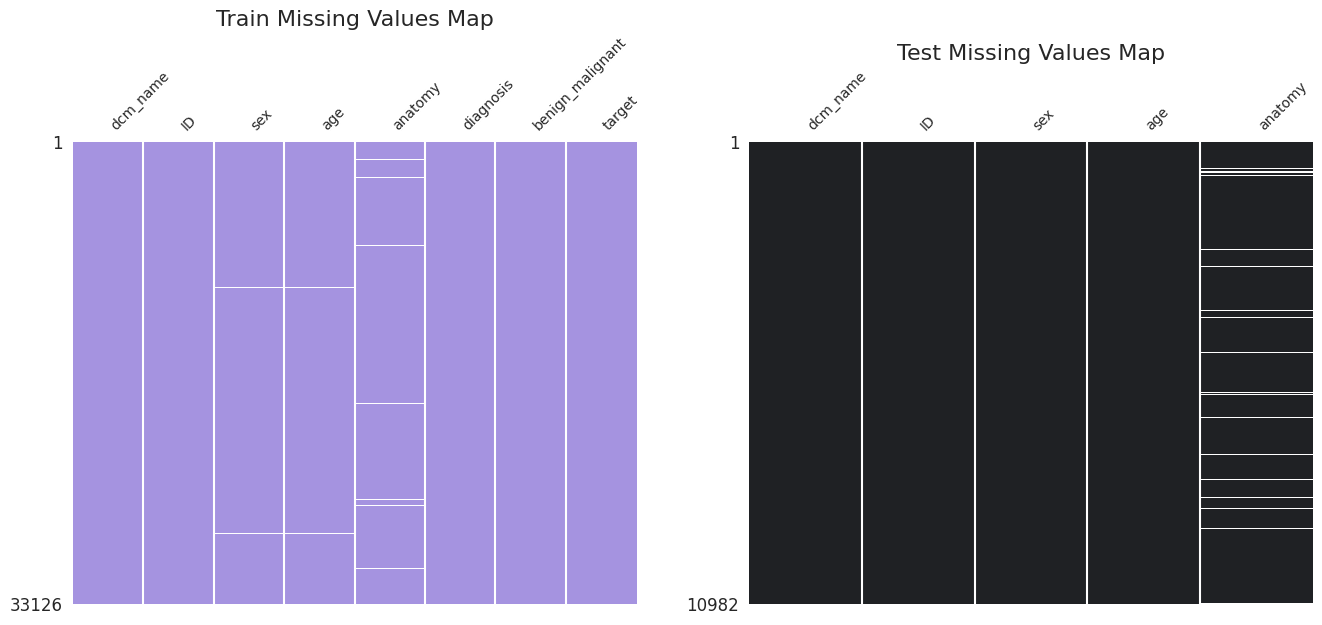

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))
#(165, 147, 224)
#(224, 227, 218)
#(31, 33, 36)
msno.matrix(train_df, ax = ax1, color=(165/255, 147/255, 224/255), fontsize=10)
msno.matrix(test_df, ax = ax2, color=(31/255, 33/255, 36/255), fontsize=10)

ax1.set_title('Train Missing Values Map', fontsize = 16)
ax2.set_title('Test Missing Values Map', fontsize = 16);

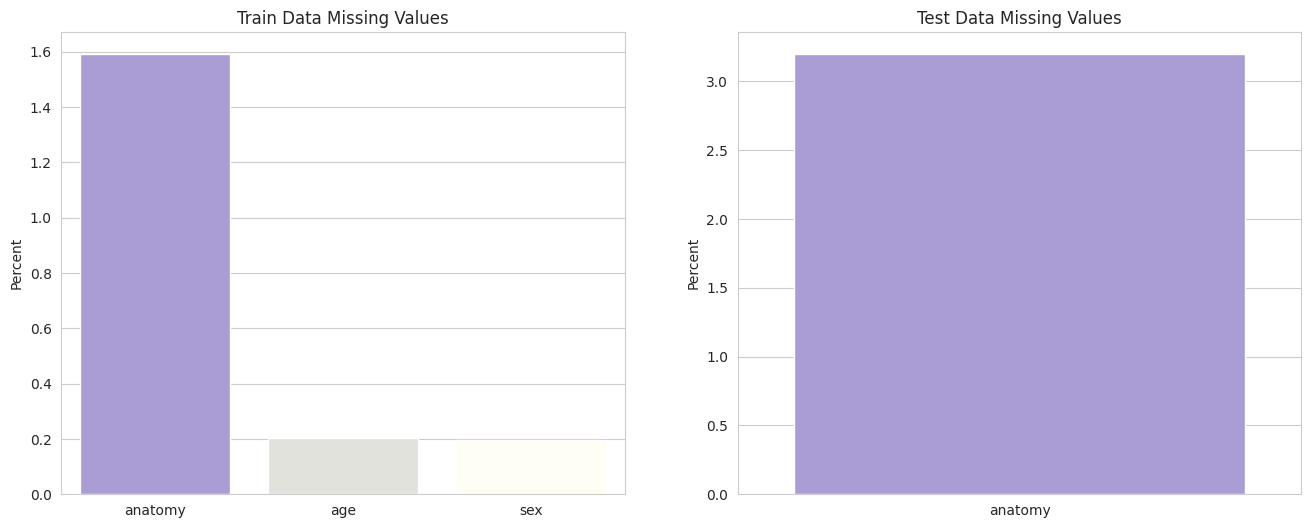

In [9]:
# Checking missing values:

def missing_percentage(df):

    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


missing_train = missing_percentage(train_df)
missing_test = missing_percentage(test_df)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=missing_train.index,
            y='Percent',
            data=missing_train,
            palette=colors_nude,
            ax=ax[0])

sns.barplot(x=missing_test.index,
            y='Percent',
            data=missing_test,
            palette=colors_nude,
            ax=ax[1])

ax[0].set_title('Train Data Missing Values')
ax[1].set_title('Test Data Missing Values')

plt.show()

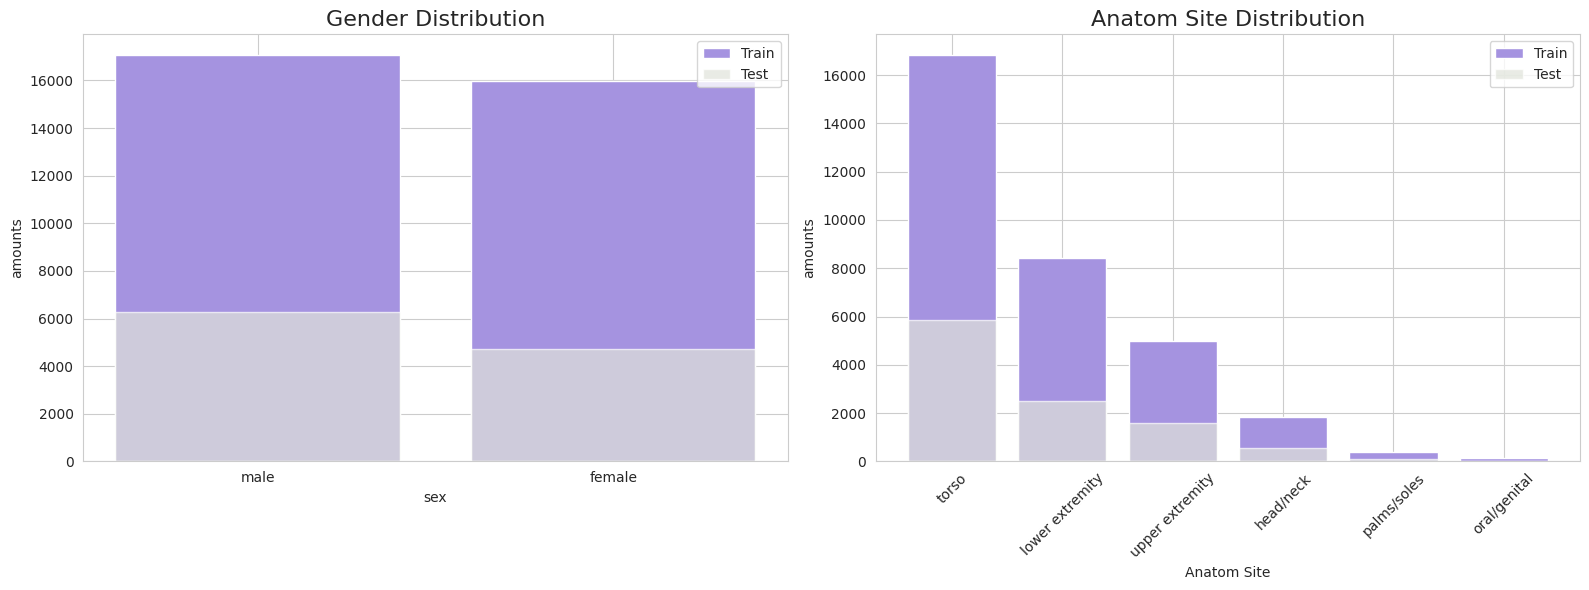

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置中文字体
rcParams['font.sans-serif'] = ['SimSun']  # 使用宋体
rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 假设 train 和 test 数据已经加载为 DataFrame
# train = pd.read_csv('train.csv')  # 请根据实际情况加载数据
# test = pd.read_csv('test.csv')    # 请根据实际情况加载数据

# 合并 train 和 test 数据集
train = train_df
test = test_df

# 创建图形和子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 计算性别统计图
sex_counts_train = train['sex'].value_counts()
sex_counts_test = test['sex'].value_counts()

# 绘制性别统计图，分别使用不同的颜色
ax1.bar(sex_counts_train.index, sex_counts_train.values, color='#A593E0', label='Train')
ax1.bar(sex_counts_test.index, sex_counts_test.values, color='#E0E3DA', label='Test', alpha=0.7)

ax1.set_title('Gender Distribution', fontsize=16)
ax1.set_xlabel('sex')
ax1.set_ylabel('amounts')
ax1.legend()

# 计算解剖部位统计图
anatomy_counts_train = train['anatomy'].value_counts()
anatomy_counts_test = test['anatomy'].value_counts()

# 绘制解剖部位统计图，分别使用不同的颜色
ax2.bar(anatomy_counts_train.index, anatomy_counts_train.values, color='#A593E0', label='Train')
ax2.bar(anatomy_counts_test.index, anatomy_counts_test.values, color='#E0E3DA', label='Test', alpha=0.7)

ax2.set_title('Anatom Site Distribution', fontsize=16)
ax2.set_xlabel('Anatom Site')
ax2.set_ylabel('amounts')
ax2.tick_params(axis='x', rotation=45)  # 让解剖部位名称更易读
ax2.legend()

# 显示图形
plt.tight_layout()
plt.show()


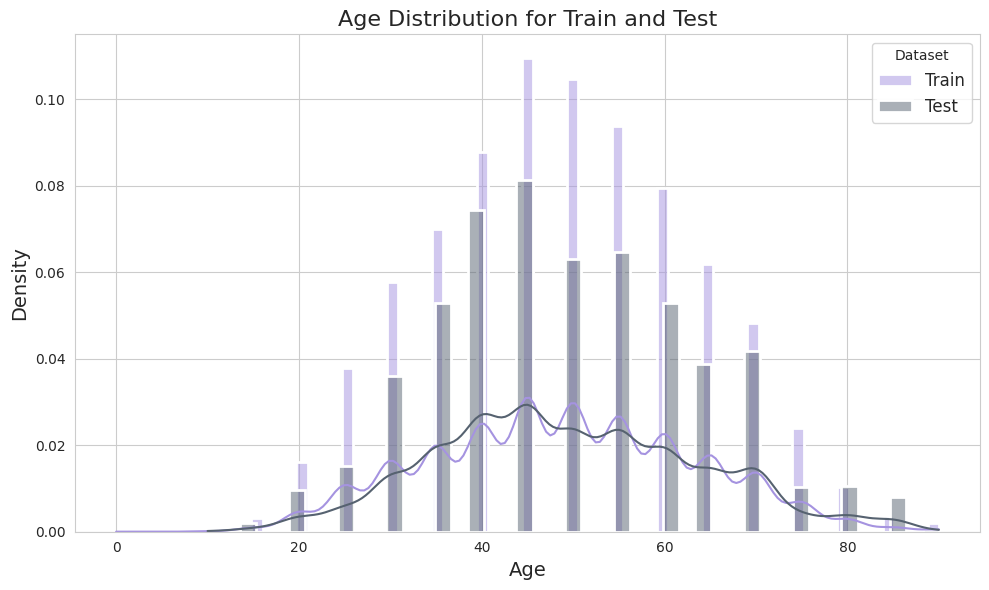

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(train_df['age'], kde=True, label='Train', color='#A593E0', stat="density", linewidth=2)
sns.histplot(test_df['age'], kde=True, label='Test', color='#566270', stat="density", linewidth=2)
plt.title('Age Distribution for Train and Test', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Dataset', fontsize=12)
plt.tight_layout()
plt.show()


## 填补空确值

In [12]:
for df in [train, test]:
    df['anatomy'].fillna('unknown', inplace=True)
    
train['sex'].fillna('unknown', inplace=True)

train['age'].fillna(-1, inplace=True)

## 按性别和目标划分的身体部位比例

In [13]:
fig = px.sunburst(data_frame=train,
                  path=['target', 'sex', 'anatomy'],
                  color='sex',
                  color_discrete_sequence=colors_nude,
                  maxdepth=-1,
                  title='Sunburst Chart Benign/Malignant > Sex > Location')

fig.update_traces(textinfo='label+percent parent')
fig.update_layout(margin=dict(t=0, l=0, r=0, b=0))
fig.show()

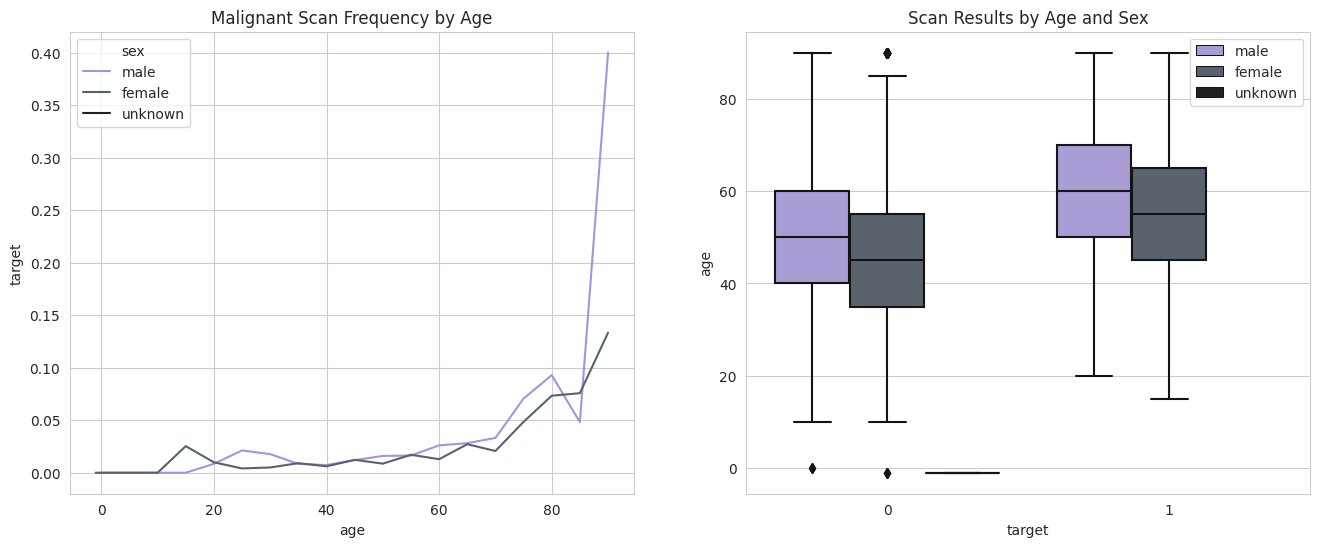

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
selected_colors = [colors_nude[i] for i in [0, 3, 4]]
sns.lineplot(x='age',
             y='target',
             data=train,
             ax=ax[0],
             hue='sex',
             palette=selected_colors,
             ci=None)
sns.boxplot(x='target',
            y='age',
            data=train,
            ax=ax[1],
            hue='sex',
            palette=selected_colors
           )

plt.legend(loc='upper right')

ax[0].set_title('Malignant Scan Frequency by Age')
ax[1].set_title('Scan Results by Age and Sex')

plt.show()

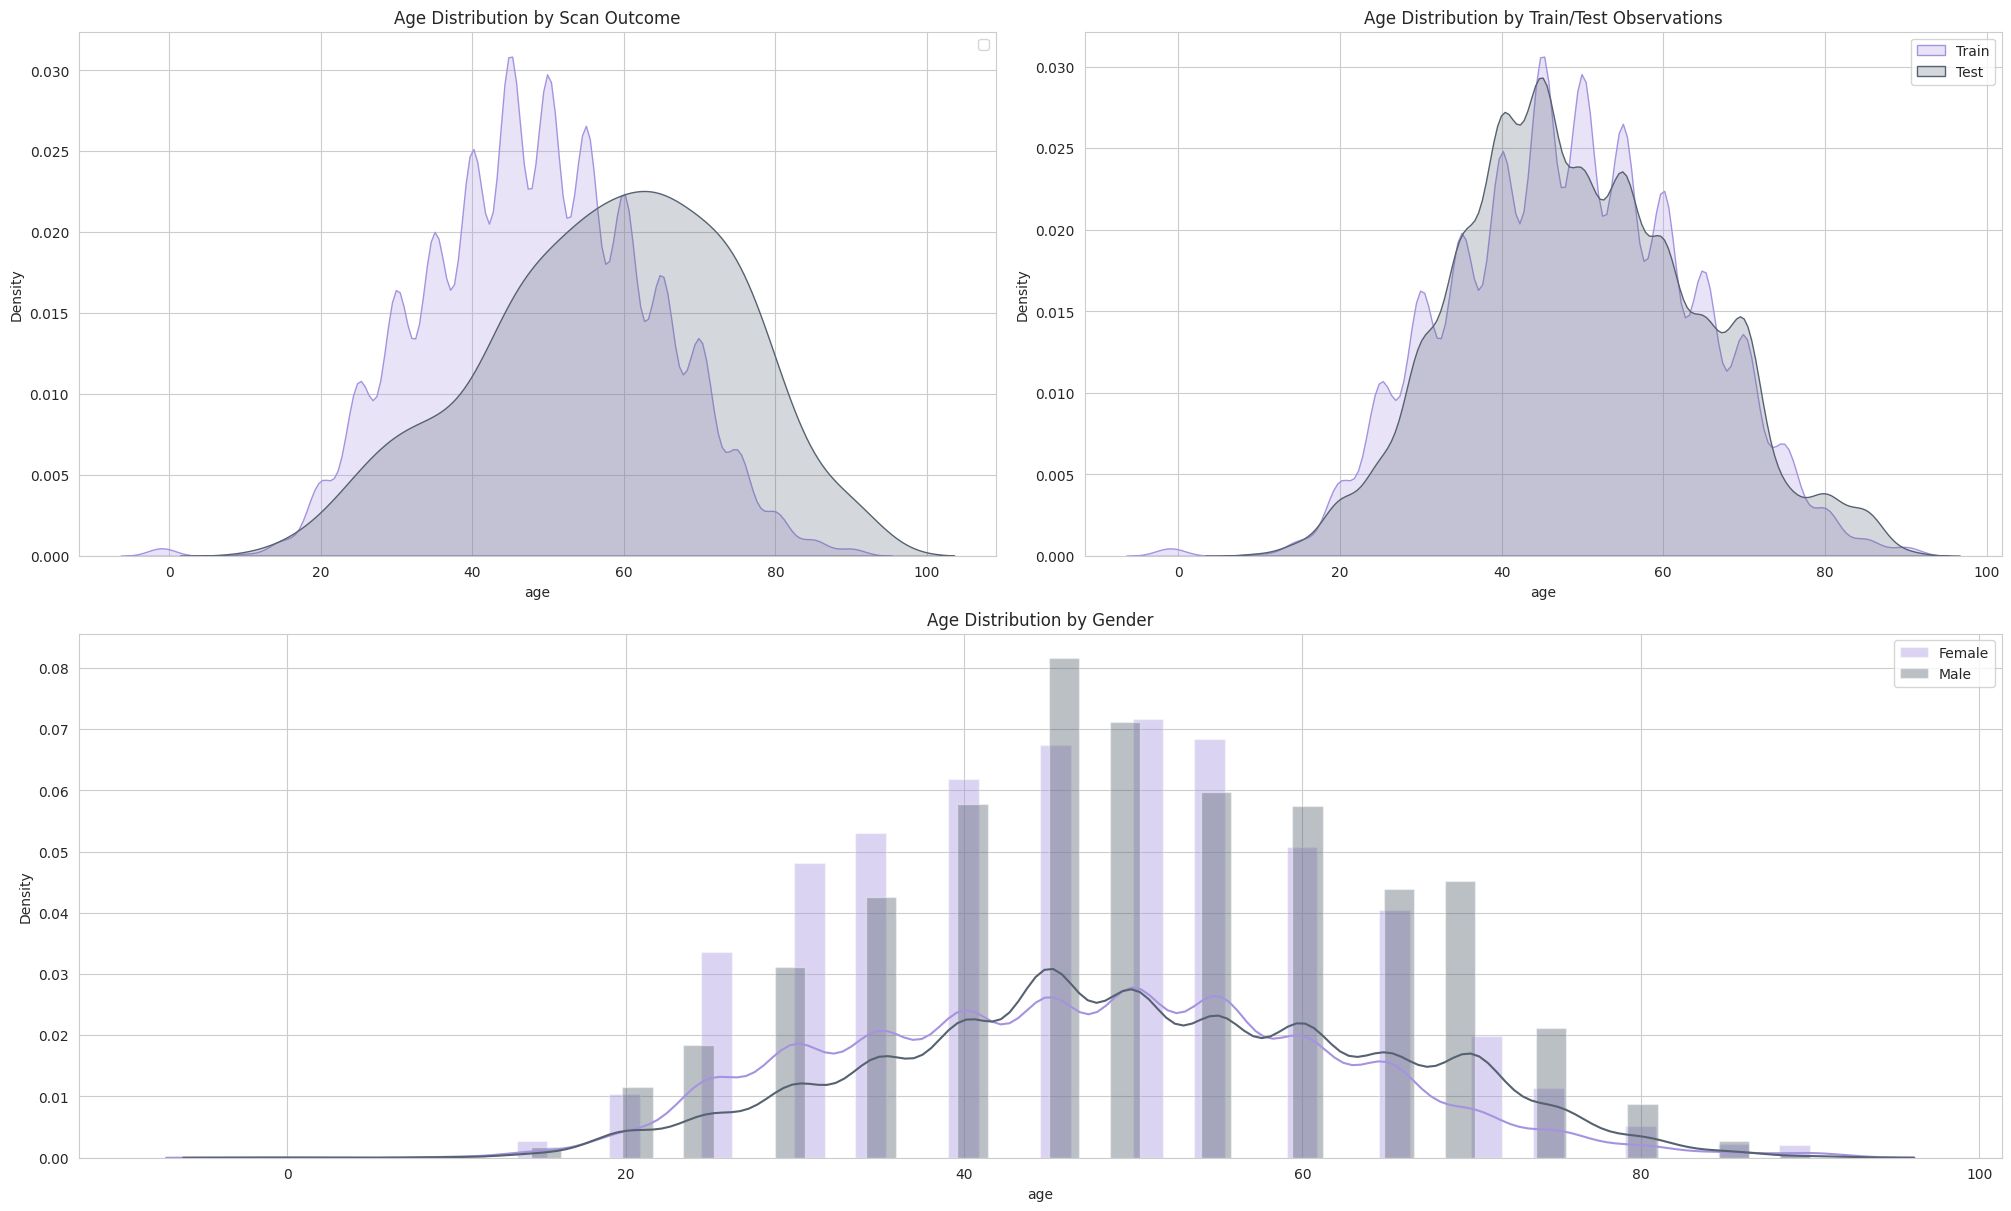

In [15]:
# Creating a customized chart and giving in figsize etc.

# Plotting age dist vs target and age dist vs datasets

fig = plt.figure(constrained_layout=True, figsize=(20, 12))

# Creating a grid

grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

# Customizing the first grid.

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('Age Distribution by Scan Outcome')

# Plot

ax1.legend()

sns.kdeplot(train[train['target'] == 0]['age'],
            shade=True,
            ax=ax1,
            color='#A593E0',
            label='Benign')
sns.kdeplot(train[train['target'] == 1]['age'],
            shade=True,
            ax=ax1,
            color='#566270',
            label='Malignant')

# Customizing second grid.

ax2 = fig.add_subplot(grid[0, 2:])

# Set the title.

ax2.set_title('Age Distribution by Train/Test Observations')

# Plot.

sns.kdeplot(train.age, label='Train', shade=True, ax=ax2, color='#A593E0')
sns.kdeplot(test.age, label='Test', shade=True, ax=ax2, color='#566270')

ax2.legend()

# Customizing third grid.

ax3 = fig.add_subplot(grid[1, :])

# Set the title.

ax3.set_title('Age Distribution by Gender')

# Plot

sns.distplot(train[train.sex == 'female'].age,
             ax=ax3,
             label='Female',
             color='#A593E0')
sns.distplot(train[train.sex == 'male'].age,
             ax=ax3,
             label='Male',
             color='#566270')
ax3.legend()

plt.show()

## 图像

Display Random Images


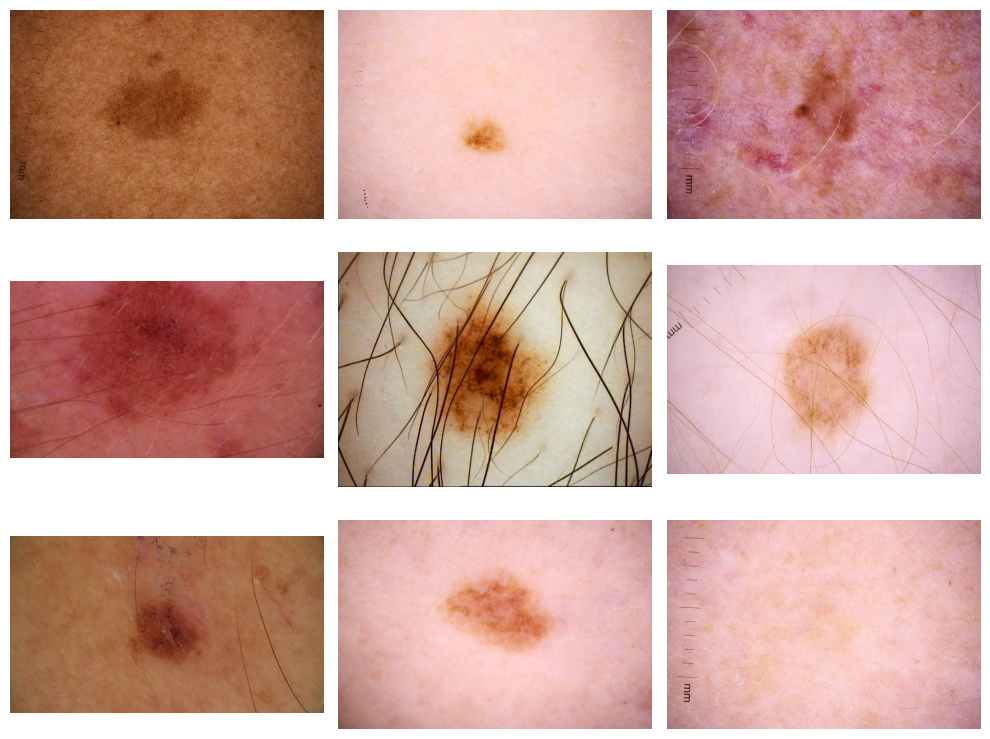

In [16]:
images = train_df['dcm_name'].values

# Extract 9 random images from it
random_images = [np.random.choice(images+'.jpg') for i in range(9)]
IMAGE_PATH = "../input/siim-isic-melanoma-classification/"
# Location of the image dir
img_dir = IMAGE_PATH+'/jpeg/train'

print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(10,8))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()   

Display benign Images


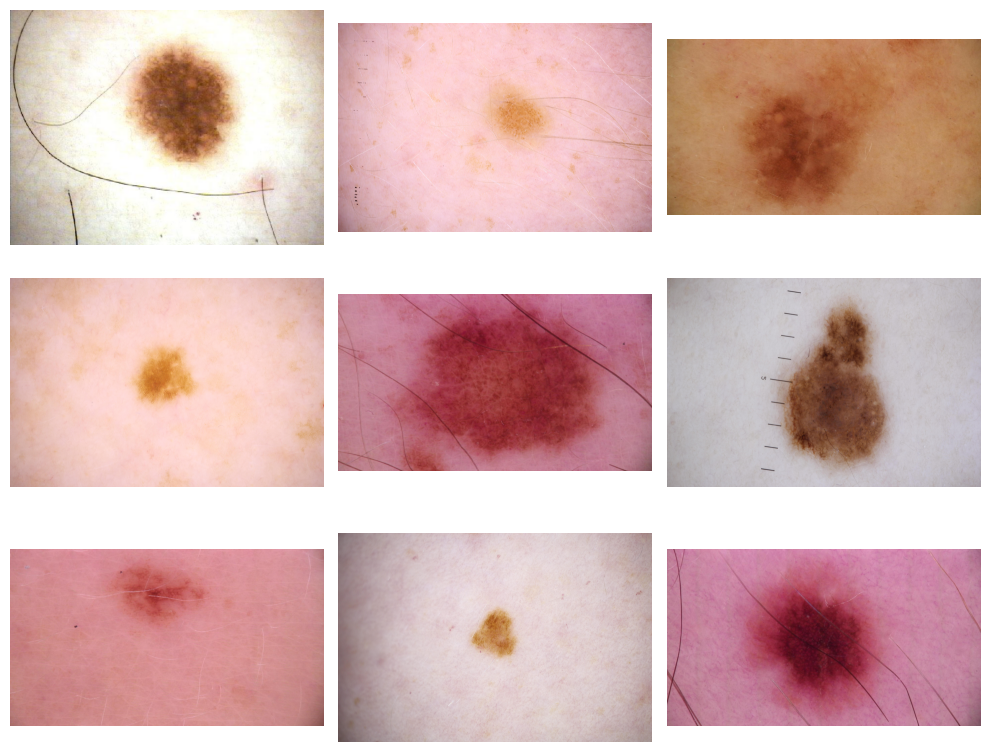

In [17]:
benign = train_df[train_df['benign_malignant']=='benign']
malignant = train_df[train_df['benign_malignant']=='malignant']
images = benign['dcm_name'].values

# Extract 9 random images from it
random_images = [np.random.choice(images+'.jpg') for i in range(9)]

# Location of the image dir
img_dir = IMAGE_PATH+'/jpeg/train'

print('Display benign Images')

# Adjust the size of your images
plt.figure(figsize=(10,8))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()   

Display malignant Images


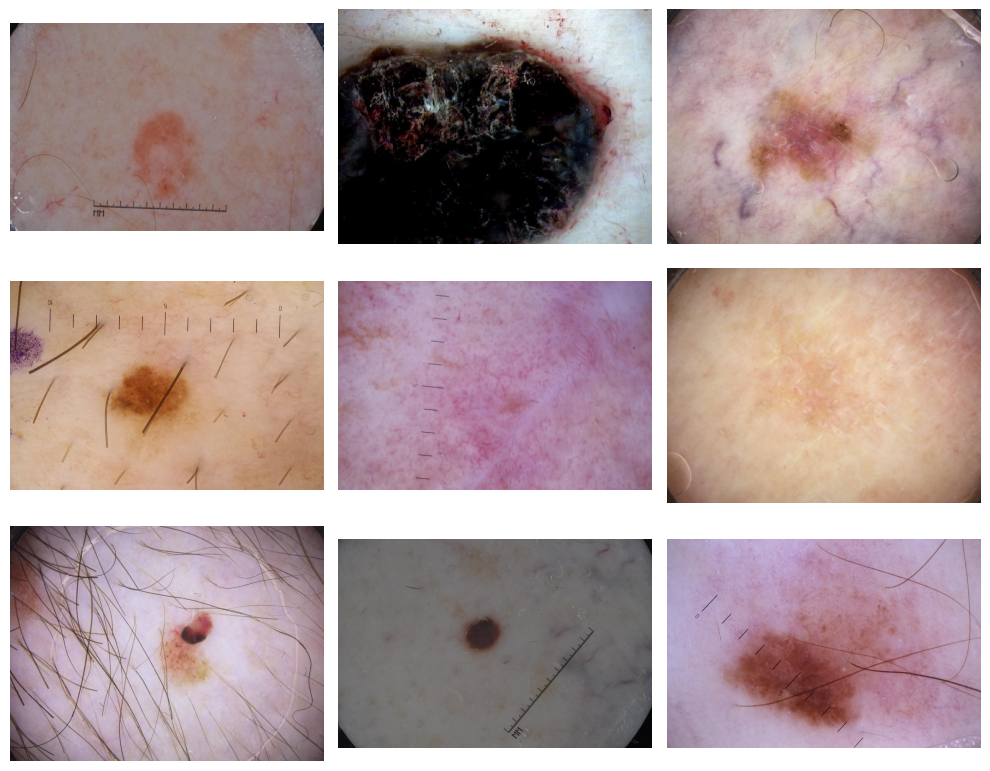

In [18]:
images = malignant['dcm_name'].values

# Extract 9 random images from it
random_images = [np.random.choice(images+'.jpg') for i in range(9)]

# Location of the image dir
img_dir = IMAGE_PATH+'/jpeg/train'

print('Display malignant Images')

# Adjust the size of your images
plt.figure(figsize=(10,8))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()   

Image dimensions:  (4000, 6000)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 169.9 ; Standard deviation : 41.3


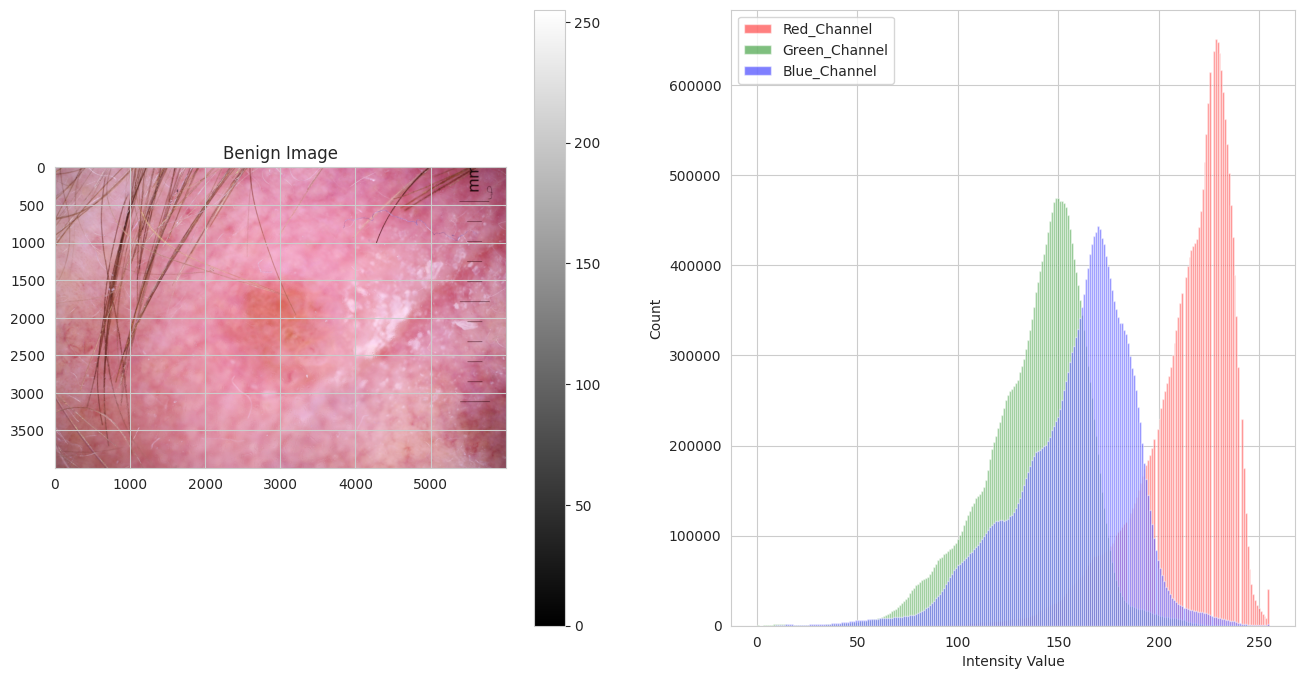

In [19]:
f = plt.figure(figsize=(16,8))
f.add_subplot(1,2, 1)

sample_img = benign['dcm_name'][0]+'.jpg'
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Benign Image')
print(f"Image dimensions:  {raw_image.shape[0],raw_image.shape[1]}")
print(f"Maximum pixel value : {raw_image.max():.1f} ; Minimum pixel value:{raw_image.min():.1f}")
print(f"Mean value of the pixels : {raw_image.mean():.1f} ; Standard deviation : {raw_image.std():.1f}")

f.add_subplot(1,2, 2)

#_ = plt.hist(raw_image.ravel(),bins = 256, color = 'orange',)
_ = plt.hist(raw_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

Image dimensions:  (2448, 3264)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 161.0 ; Standard deviation : 45.1


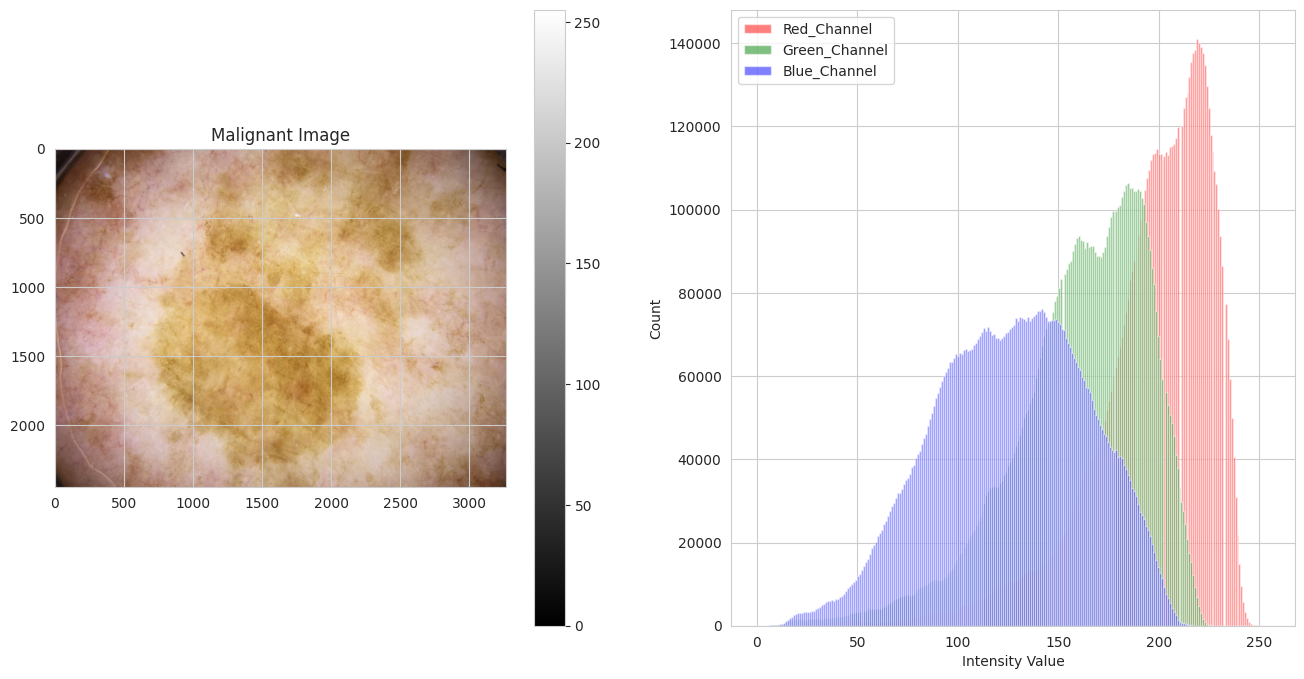

In [20]:
f = plt.figure(figsize=(16,8))
f.add_subplot(1,2, 1)

sample_img = malignant['dcm_name'][235]+'.jpg'
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Malignant Image')
print(f"Image dimensions:  {raw_image.shape[0],raw_image.shape[1]}")
print(f"Maximum pixel value : {raw_image.max():.1f} ; Minimum pixel value:{raw_image.min():.1f}")
print(f"Mean value of the pixels : {raw_image.mean():.1f} ; Standard deviation : {raw_image.std():.1f}")

f.add_subplot(1,2, 2)

#_ = plt.hist(raw_image.ravel(),bins = 256, color = 'orange',)
_ = plt.hist(raw_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()